In [1]:
from sklearn.cluster import KMeans
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
from netCDF4 import Dataset, num2date, date2num
from datetime import datetime, timedelta
import os

latList = [-9, -8, -5, -2, 0, 2, 5, 8, 9]
lonList = [-95, -110, -125, -140, -155, -170, -180, 165]

ylen = len(latList)
xlen = len(lonList)

taskList = []

for latId  in range(ylen):
    for lonId in range(xlen):
        taskList.append([latList[latId], lonList[lonId]])

ntasks = len(taskList)

i = 0
tlen = 0

metaData = np.empty((0,20), dtype=float)
metaDataIndex = ['dateTime',
                 'time',
                 'lat', 
                 'lon',
                 'U10N_QS',
                 'U10N_dir_QS',
                 'satTimeDiff',
                 'dist',
                 'satLon',
                 'satLat',
                 'U10N_TAO',
                 'U10N_dir_TAO',
                 'U10N_TAO2',
                 'U10N_dir_TAO2',
                 'U10N_x_TAO2',
                 'U10N_y_TAO2',
                 'SST_TAO',
                 'RH_TAO',
                 'AIRT_TAO',
                 'Deployment Classifier']

for task in taskList:
    lat = task[0]
    lon = task[1]

    LAT = lat
    LON = lon

    if lat < 0:
        latUnits = 'S'
    else:
        latUnits = 'N'

    if lon < 0:
        lonUnits = 'W'
        LON += 360
    else:
        lonUnits = 'E'
    
    lat=abs(lat)
    lon=abs(lon)

    matchFname = f'../../downloads/Buoy/extractedGZ/WINDS/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}_matchupNearestFour_2000.nc'
    deployFileName = f'../../downloads/Buoy/extractedGZ/WINDS/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}_DeploymentDates.nc'
    
    if os.path.isfile(matchFname):

        ds = Dataset(matchFname)
        arr = np.empty((0,1), dtype=float)
        for i in range(4,19):
            if i <= 9:
                #print(i, metaDataIndex[i])
                readArr = np.array([ds.variables[metaDataIndex[i]][0,:]]).T
                #print(readArr.shape)
                #print(arr.shape)
                if len(arr) == 0:
                    arr = np.concatenate((arr, readArr), axis = 0)
                else:
                    arr = np.concatenate((arr, readArr), axis = 1)
            else:
                #print(i, metaDataIndex[i])
                readArr = np.array([ds.variables[metaDataIndex[i]][:]]).T
                #print(readArr.shape)
                #print(arr.shape)
                arr = np.concatenate((arr, readArr), axis = 1)

        latArr = np.array([len(arr)*[LAT]]).T
        lonArr = np.array([len(arr)*[LON]]).T
        timeArr = np.array(ds.variables['time'])
        timeUnit = ds.variables['time'].units
        cftimes = num2date(timeArr, timeUnit)
        dateTimeArr = np.array([datetime(dtm.year, dtm.month, dtm.day, dtm.hour, dtm.minute) for dtm in cftimes])

        # latArr = latArr[:,np.newaxis]
        # lonArr = lonArr[:,np.newaxis]
        
        
        #print('lonArr', lonArr.shape)
        arr = np.concatenate((lonArr, arr), axis=1)

        #print('latArr', latArr.shape)
        arr = np.concatenate((latArr, arr), axis=1)

        #print('timeArr', timeArr.shape)
        timeArr = timeArr[:,np.newaxis]
        arr = np.concatenate((timeArr, arr), axis=1)

        dateTimeArr = dateTimeArr[:,np.newaxis]
        arr = np.concatenate((dateTimeArr, arr), axis=1)

        ds2 = Dataset(deployFileName)
        startDates = np.array(ds2.variables['startDate'])
        endDates = np.array(ds2.variables['endDate'])

        depNum = np.zeros((len(arr),1), dtype=int)
        c = 1
        for i in range(1,len(startDates)):
            mask = timeArr >= startDates[i]
            mask *= timeArr <= endDates[i]
            depNum[mask] = c
            c = c+1

        arr = np.concatenate((arr, depNum), axis=1)


        metaData = np.concatenate((metaData, arr), axis=0)
        #ds = ds.expand_dims('lat', axis= 0)
        

nanVals = np.array(np.sum(metaData[:,1:], axis=1), dtype=float)
mask = np.isnan(nanVals)
print('MetaData.shape', metaData.shape, 'masked rows', np.sum(mask))
metaData = metaData[~mask, :]
print('new MetaData.shape', metaData.shape)


df = pd.DataFrame(metaData, columns = metaDataIndex )
df['speedDiff'] = df['U10N_QS'] - df['U10N_TAO']
df['absSpeedDiff'] = abs(df['U10N_QS'] - df['U10N_TAO'])

dDiff = (df['U10N_dir_QS'] - df['U10N_dir_TAO'])%360
dDiff[dDiff > 180] -= 360 #- dDiff[dDiff > 180] 
dDiff[dDiff < -180] += 360
df['directionDiff'] = dDiff
df['absDirectionDiff'] = abs(dDiff)

MetaData.shape (199639, 20) masked rows 7925
new MetaData.shape (191714, 20)


In [2]:
df.head()

dateTime         time  lat    lon   U10N_QS U10N_dir_QS  \
0 2000-01-01 00:30:00  315534600.0 -8.0  265.0   5.74714  325.648834   
1 2000-01-01 00:40:00  315535200.0 -8.0  265.0   5.74714  325.648834   
2 2000-01-02 23:40:00  315704400.0 -8.0  265.0  6.211579  323.708984   
3 2000-01-02 23:50:00  315705000.0 -8.0  265.0  6.211579  323.708984   
4 2000-01-03 12:10:00  315749400.0 -8.0  265.0  5.837174  318.623627   

  satTimeDiff      dist      satLon    satLat  ... U10N_x_TAO2 U10N_y_TAO2  \
0       276.0  6.455491  265.053436 -7.976122  ...   -3.276446    4.936657   
1      -324.0  6.455491  265.053436 -7.976122  ...   -3.612193    4.592328   
2       271.0  6.615148  264.974976 -7.945916  ...   -3.463514    4.321145   
3      -329.0  6.615148  264.974976 -7.945916  ...   -3.797712     4.63189   
4       457.0  5.688329  265.045563 -7.975894  ...   -4.058911    4.486742   

     SST_TAO     RH_TAO   AIRT_TAO Deployment Classifier speedDiff  \
0  23.745001  73.830002      22.93                     0 -0.179021   
1     23.743  73.300003      22.84                     0 -0.089785   
2     23.938  75.730003  23.200001                     0  0.670052   
3  23.927999  75.599998  23.190001                     0  0.218719   
4  23.716999  73.879997  23.040001                     0  -0.21819   

  absSpeedDiff directionDiff absDirectionDiff  
0     0.179021      -0.75116          0.75116  
1     0.089785      3.848846         3.848846  
2     0.670052      2.408997         2.408997  
3     0.218719      3.108978         3.108978  
4      0.21819      0.823639         0.823639  

[5 rows x 24 columns]

In [3]:
yearmonth = np.zeros((len(df)), dtype=int)
month = np.zeros((len(df)), dtype=int)
for year in range(2000,2008):
    for mth in range(1,13):
        curYearMonth = year*100 + mth
        mask =np.array([dtm.year == year and dtm.month == mth for dtm in df['dateTime']])
        yearmonth[mask] = curYearMonth

for mth in range(1,13):
    curMonth = mth
    mask =np.array([dtm.month == mth for dtm in df['dateTime']])
    month[mask] = curMonth


df['yearmonth'] = yearmonth
df['month'] = month

In [4]:
df

dateTime         time  lat    lon    U10N_QS U10N_dir_QS  \
0      2000-01-01 00:30:00  315534600.0 -8.0  265.0    5.74714  325.648834   
1      2000-01-01 00:40:00  315535200.0 -8.0  265.0    5.74714  325.648834   
2      2000-01-02 23:40:00  315704400.0 -8.0  265.0   6.211579  323.708984   
3      2000-01-02 23:50:00  315705000.0 -8.0  265.0   6.211579  323.708984   
4      2000-01-03 12:10:00  315749400.0 -8.0  265.0   5.837174  318.623627   
...                    ...          ...  ...    ...        ...         ...   
191709 2006-12-30 15:10:00  536339400.0  9.0  220.0   9.060904  251.005539   
191710 2006-12-31 03:40:00  536384400.0  9.0  220.0  10.913956  239.481735   
191711 2006-12-31 03:50:00  536385000.0  9.0  220.0  10.913956  239.481735   
191712 2006-12-31 14:40:00  536424000.0  9.0  220.0  10.722863  244.993149   
191713 2006-12-31 14:50:00  536424600.0  9.0  220.0  10.722863  244.993149   

       satTimeDiff      dist      satLon    satLat  ...    SST_TAO     RH_TAO  \
0            276.0  6.455491  265.053436 -7.976122  ...  23.745001  73.830002   
1           -324.0  6.455491  265.053436 -7.976122  ...     23.743  73.300003   
2            271.0  6.615148  264.974976 -7.945916  ...     23.938  75.730003   
3           -329.0  6.615148  264.974976 -7.945916  ...  23.927999  75.599998   
4            457.0  5.688329  265.045563 -7.975894  ...  23.716999  73.879997   
...            ...       ...         ...       ...  ...        ...        ...   
191709       -42.0  6.435526  219.981033   8.94524  ...  26.754999  94.370003   
191710        86.0  0.888303   219.99202  9.001301  ...     26.757  88.559998   
191711      -514.0  0.888303   219.99202  9.001301  ...  26.754999       88.0   
191712       205.0  1.812441  219.997299   8.98392  ...  26.660999  93.629997   
191713      -395.0  1.812441  219.997299   8.98392  ...  26.662001  94.330002   

         AIRT_TAO Deployment Classifier speedDiff absSpeedDiff directionDiff  \
0           22.93                     0 -0.179021     0.179021      -0.75116   
1           22.84                     0 -0.089785     0.089785      3.848846   
2       23.200001                     0  0.670052     0.670052      2.408997   
3       23.190001                     0  0.218719     0.218719      3.108978   
4       23.040001                     0  -0.21819      0.21819      0.823639   
...           ...                   ...       ...          ...           ...   
191709  25.299999                    10  2.689547     2.689547     17.005539   
191710      26.26                    10  0.276167     0.276167      7.981735   
191711      26.27                    10  0.433704     0.433704      7.181732   
191712  25.110001                    10  -1.01704      1.01704     10.993149   
191713      25.17                    10 -0.100943     0.100943     12.593155   

       absDirectionDiff yearmonth month  
0               0.75116    200001     1  
1              3.848846    200001     1  
2              2.408997    200001     1  
3              3.108978    200001     1  
4              0.823639    200001     1  
...                 ...       ...   ...  
191709        17.005539    200612    12  
191710         7.981735    200612    12  
191711         7.181732    200612    12  
191712        10.993149    200612    12  
191713        12.593155    200612    12  

[191714 rows x 26 columns]

In [5]:
selectX = [#'time',
           #'U10N_QS',
           #'U10N_dir_QS',
           #'satTimeDiff',
           #'dist',
           #'U10N_TAO',
           #'U10N_dir_TAO',
           #'U10N_x_TAO2',
           #'U10N_y_TAO2',
           #'SST_TAO',
           #'RH_TAO',
           #'AIRT_TAO',
           'speedDiff',
           'directionDiff',
           #'absSpeedDiff',
           #'absDirectionDiff'
            ]

X = df[selectX]
normX = (X - X.mean(axis=0))/ X.std(axis=0)
kmeans = KMeans(n_clusters=9, random_state=0, n_init="auto", max_iter = 10000).fit(normX)
df['label'] = kmeans.labels_

In [6]:
lat = 0
lon = -140
LAT = lat
LON = lon%360

if lat < 0:
    latUnits = 'S'
else:
    latUnits = 'N'

if lon < 0:
    lonUnits = 'W'
else:
    lonUnits = 'E'

lat=abs(lat)
lon=abs(lon)

returnText = f'{lat:02d}{latUnits} | {lon:03d}{lonUnits} | 2000 '

subDF = df.loc[df['lat'] == LAT]
subDF = subDF.loc[subDF['lon'] == LON]

In [7]:
subDF.head()

dateTime         time  lat    lon   U10N_QS U10N_dir_QS  \
86793 2000-01-03 03:00:00  315716400.0  0.0  220.0    4.8585  268.322998   
86794 2000-01-03 03:10:00  315717000.0  0.0  220.0    4.8585  268.322998   
86795 2000-01-03 15:40:00  315762000.0  0.0  220.0  7.341095  278.933258   
86796 2000-01-03 15:50:00  315762600.0  0.0  220.0  7.341095  278.933258   
86797 2000-01-04 15:10:00  315846600.0  0.0  220.0  7.374207  266.399017   

      satTimeDiff      dist      satLon    satLat  ...     RH_TAO   AIRT_TAO  \
86793       251.0  8.322387  219.941528  0.046721  ...  85.849998  23.450001   
86794      -349.0  8.322387  219.941528  0.046721  ...  86.199997      23.35   
86795       100.0  6.288885  219.964111  0.043712  ...  86.660004      23.51   
86796      -500.0  6.288885  219.964111  0.043712  ...  87.139999  23.540001   
86797       397.0  1.344787   219.98793 -0.000766  ...  85.870003      23.41   

      Deployment Classifier speedDiff absSpeedDiff directionDiff  \
86793                     0 -0.412245     0.412245     -8.377014   
86794                     0 -0.511419     0.511419      -3.97699   
86795                     0 -1.175273     1.175273    -13.966736   
86796                     0  -0.46537      0.46537     -9.966736   
86797                     0 -0.600362     0.600362     -8.700989   

      absDirectionDiff yearmonth month label  
86793         8.377014    200001     1     1  
86794          3.97699    200001     1     1  
86795        13.966736    200001     1     4  
86796         9.966736    200001     1     1  
86797         8.700989    200001     1     1  

[5 rows x 27 columns]

In [8]:
def plotRegSlopeInterceptAndRsq(xDates,y,ax, regLabel = '', colors = ['blue', 'purple']):
    sDate=xDates[0]
    eDate=xDates[-1]
    xUnit = f'seconds since {sDate.year}-{sDate.month:02d}-{sDate.day:02d}-{sDate.hour:02d}:{sDate.minute:02d}:{sDate.second:02d}'
    seconds = np.array(date2num(xDates,xUnit), dtype=float)
    y = np.array(y, dtype=float)
    ax.scatter(xDates, y, s=1, color=colors[0], alpha=0.25)

    #res = stats.linregress(seconds, y)
    
    res = stats.siegelslopes(y, seconds)

    xs = float(seconds[0])
    xe = float(seconds[-1])

    dx = (xe - xs)/100

    try:
        x=np.arange(xs, xe, dx)
        #print('ok', xs, xe, dx)
    except:
        print(xs, xe, dx)
        print('len xDates', len(xDates))
        sys.exit()

    xDates = num2date(x,xUnit)
    
    ax.plot(xDates, res.intercept + res.slope*x, color=colors[1], linewidth = 3, label='fitted line ' + regLabel)
    return res.slope/3600, res.intercept + res.slope*xs

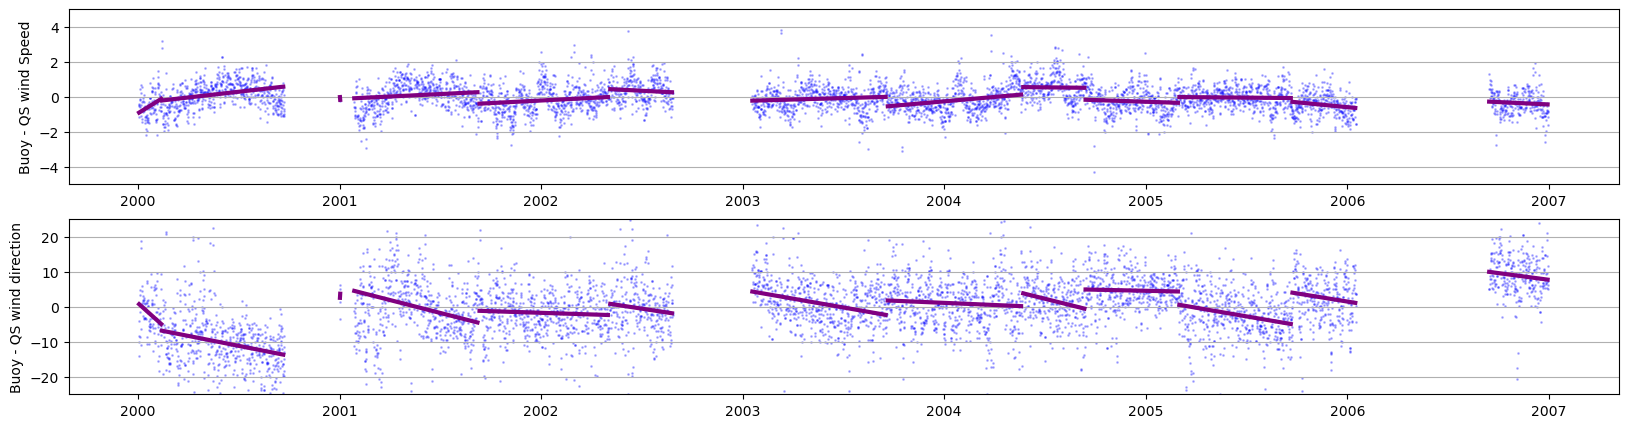

In [9]:
depLb = subDF['Deployment Classifier'].to_list()
depLb = list(set(depLb))

fig, axes = plt.subplots(nrows=2, ncols =1, figsize=(20,5))

for i in range(len(depLb)):
    dep = depLb[i]
    ssubDF = subDF.loc[subDF['Deployment Classifier'] == dep]
    dates = pd.to_datetime(ssubDF['dateTime'])
    y = dates.dt.year.to_list()
    m = dates.dt.month.to_list()
    d = dates.dt.day.to_list()
    h = dates.dt.hour.to_list()
    mm = dates.dt.minute.to_list()
    ss = dates.dt.second.to_list()
    dateList = np.array([datetime(y[i],m[i],d[i],h[i],mm[i],ss[i]) for i in range(len(dates))])
    
    
    if len(dates)>2:
        x = dateList
        y1 = ssubDF['speedDiff'].to_numpy()
        angleDiff = ssubDF['directionDiff'].to_numpy()
        angleDiff[angleDiff>180] = 360 - angleDiff[angleDiff>180]
        angleDiff[angleDiff<-180] += 360
        y2 = angleDiff
        

        
        wspdDevRate, wspdStartDev = plotRegSlopeInterceptAndRsq(x,y1, axes[0], regLabel = '')
        axes[0].set_ylim(-5,5)
        axes[0].yaxis.grid(visible=True, which='major')
        axes[0].set_ylabel('Buoy - QS wind Speed')

        wdirDevRate, wdirStartDev = plotRegSlopeInterceptAndRsq(x,y2, axes[1], regLabel = '')
        axes[1].set_ylim(-25,25)
        axes[1].yaxis.grid(visible=True, which='major')
        axes[1].set_ylabel('Buoy - QS wind direction')


###################################################################

# text = f'{lat:d}{latUnits} {lon:d}{lonUnits} 10min-matchup buoy Neutral Winds with QS data 2000'
# fig.suptitle(text, y = 0.9)
# plt.subplots_adjust(hspace=0.5)

# fname = f'images/SusanLike_{lat:02d}{latUnits}_{lon:03d}{lonUnits}_Comp_2000to2007.png'
# plt.savefig(fname,dpi=70)
# plt.close()
# print(returnText)
# return returnText

In [10]:
import seaborn as sns

/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecat

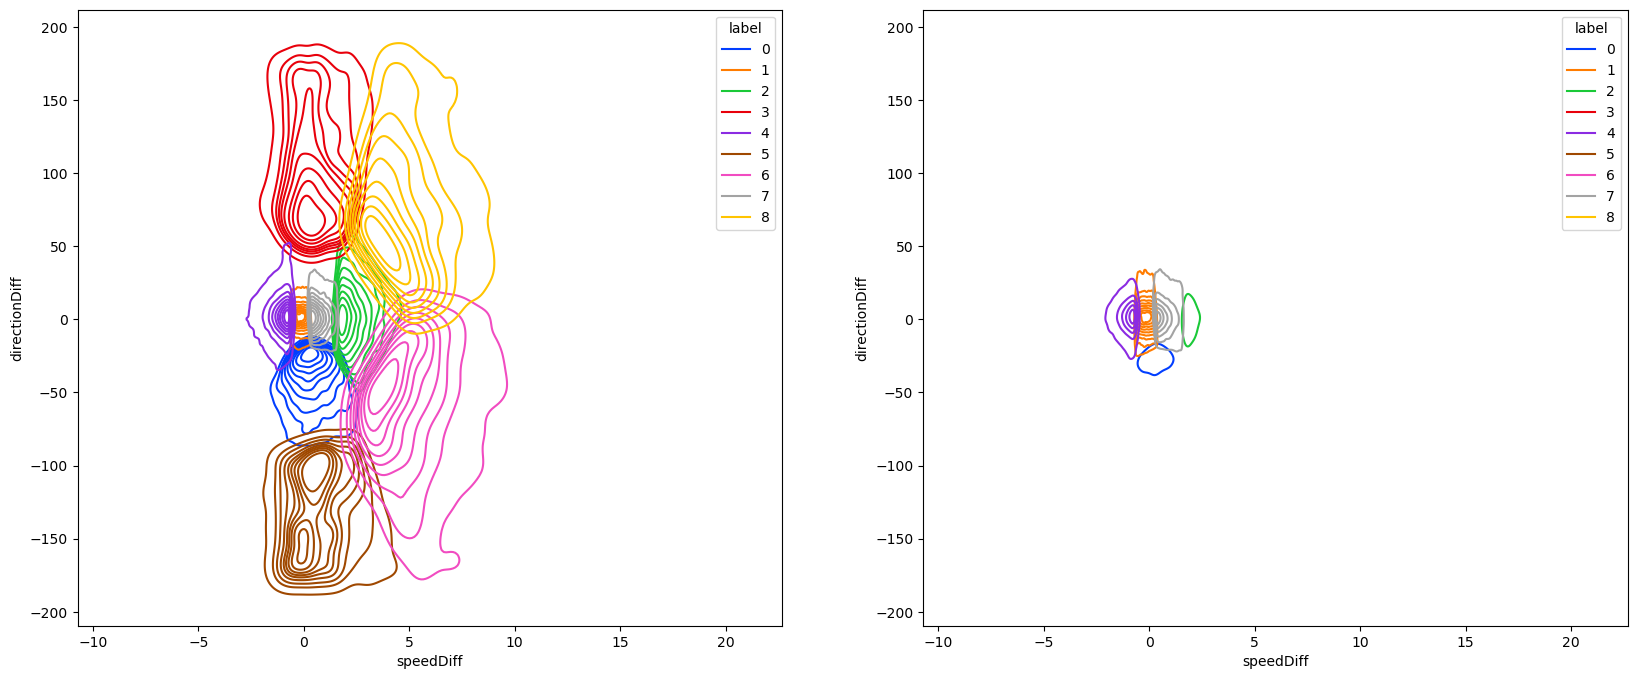

In [11]:
fig, axes = plt.subplots(ncols=2, figsize = (20,8))
xlabel = 'speedDiff'
ylabel = 'directionDiff'
s = sns.kdeplot(df, x=xlabel, y = ylabel,levels=10, 
                hue='label', common_norm=False,
                palette = sns.color_palette("bright"), ax = axes[0])

s = sns.kdeplot(df, x=xlabel, y = ylabel,levels=10, 
                hue='label', common_norm=True,
                palette = sns.color_palette("bright"), ax = axes[1])

/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecat

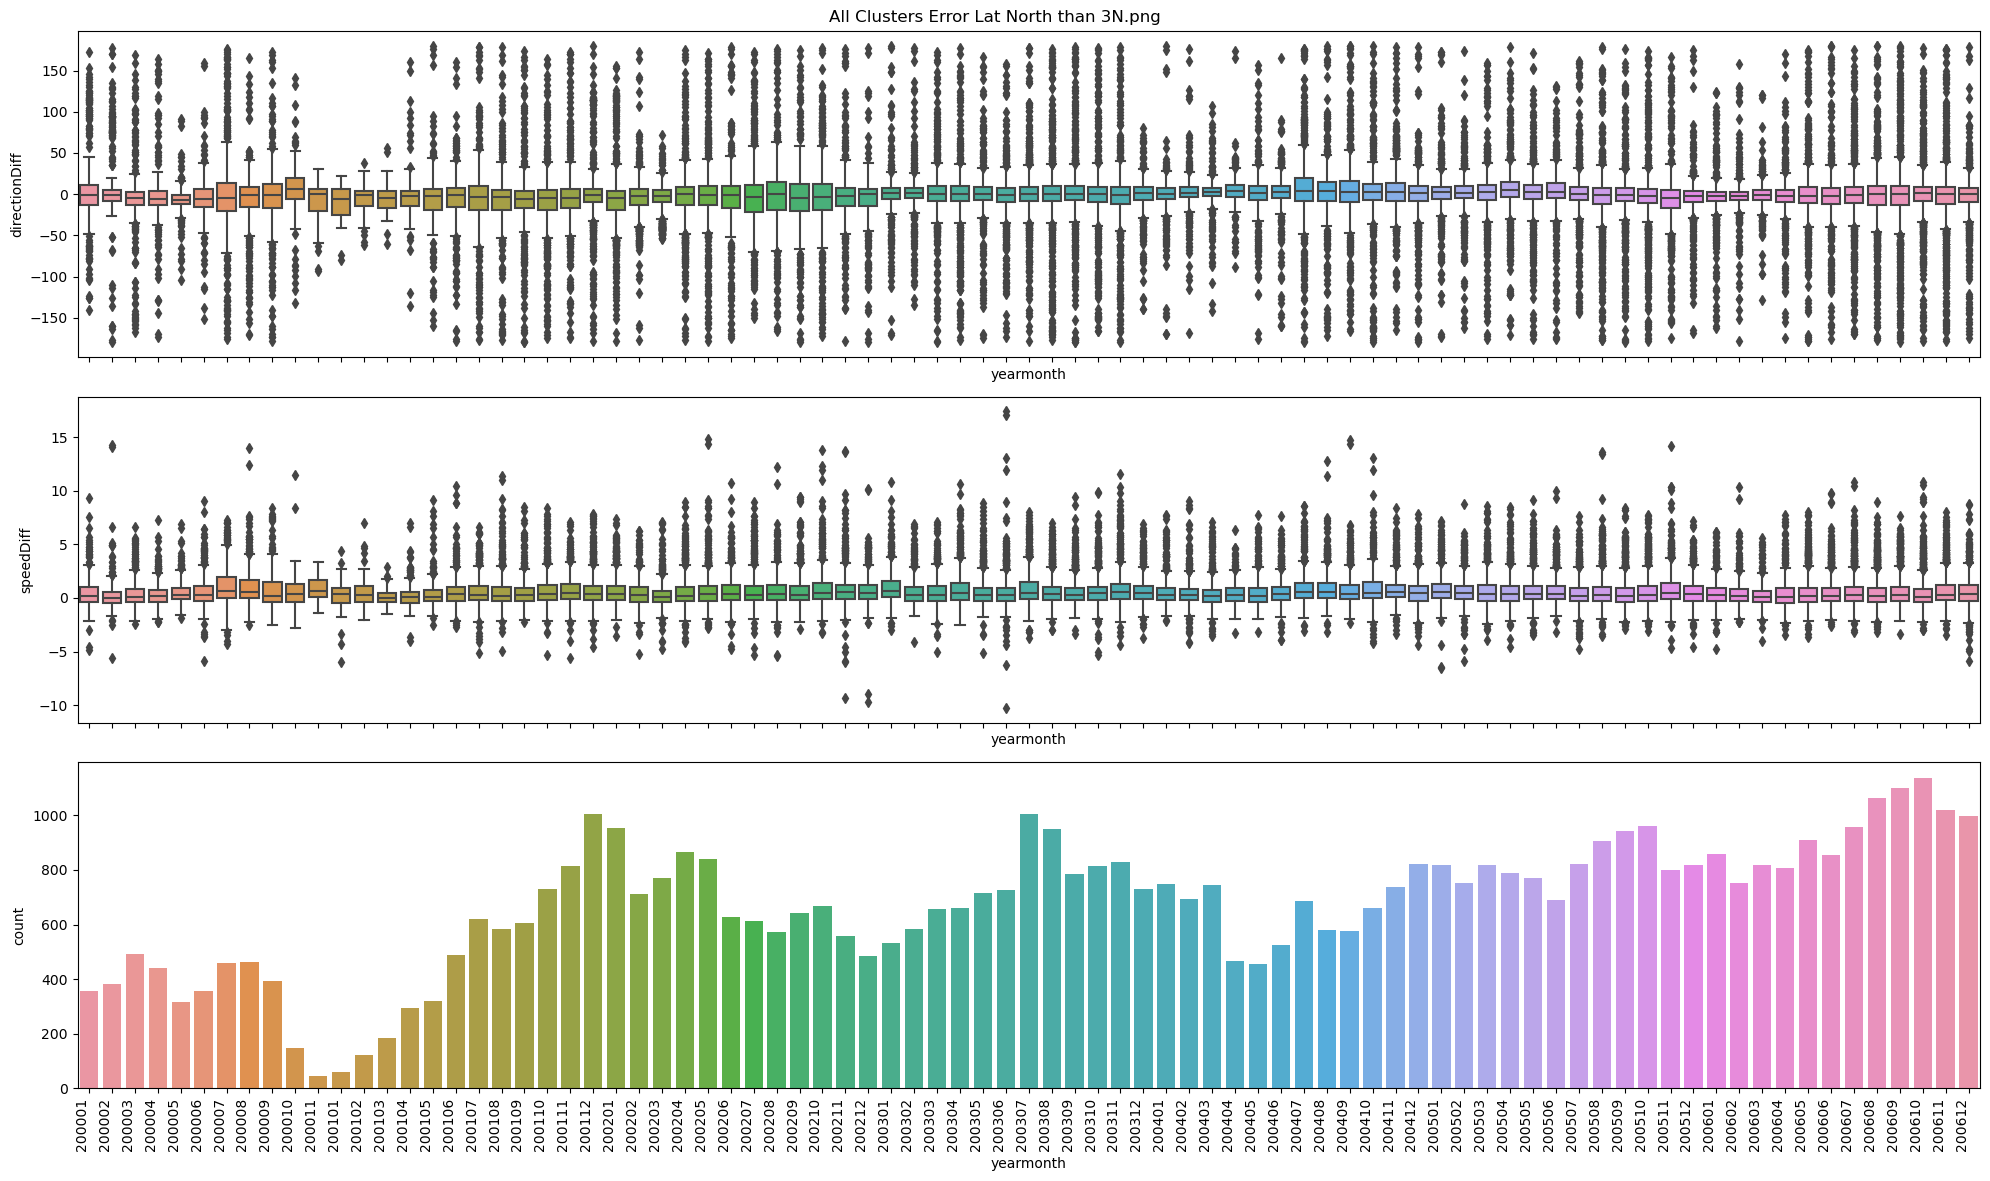

In [12]:
fig, axes = plt.subplots(nrows=3, figsize=(20,12), sharex=True)
lat = 3
lon = -140
subDF = df.loc[df['lat'] >= lat]
#subDF = subDF.loc[subDF['label'].isin([0,2,3,5,6,8])]
#subDF = subDF.loc[subDF['lon'] == lon%360]

ax = axes[0]
sns.boxplot(subDF, x="yearmonth", y="directionDiff", ax =ax)
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=90, ha='right')

ax = axes[1]
sns.boxplot(subDF, x="yearmonth", y="speedDiff", ax =ax)
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=90, ha='right')

ax = axes[2]
sns.countplot(subDF, x="yearmonth", ax =ax)
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=90, ha='right')

plt.suptitle('All Clusters Error Lat North than 3N.png')

plt.tight_layout()

plt.savefig('AllClustersError_LatNorththan3.png', dpi=100)

/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecat

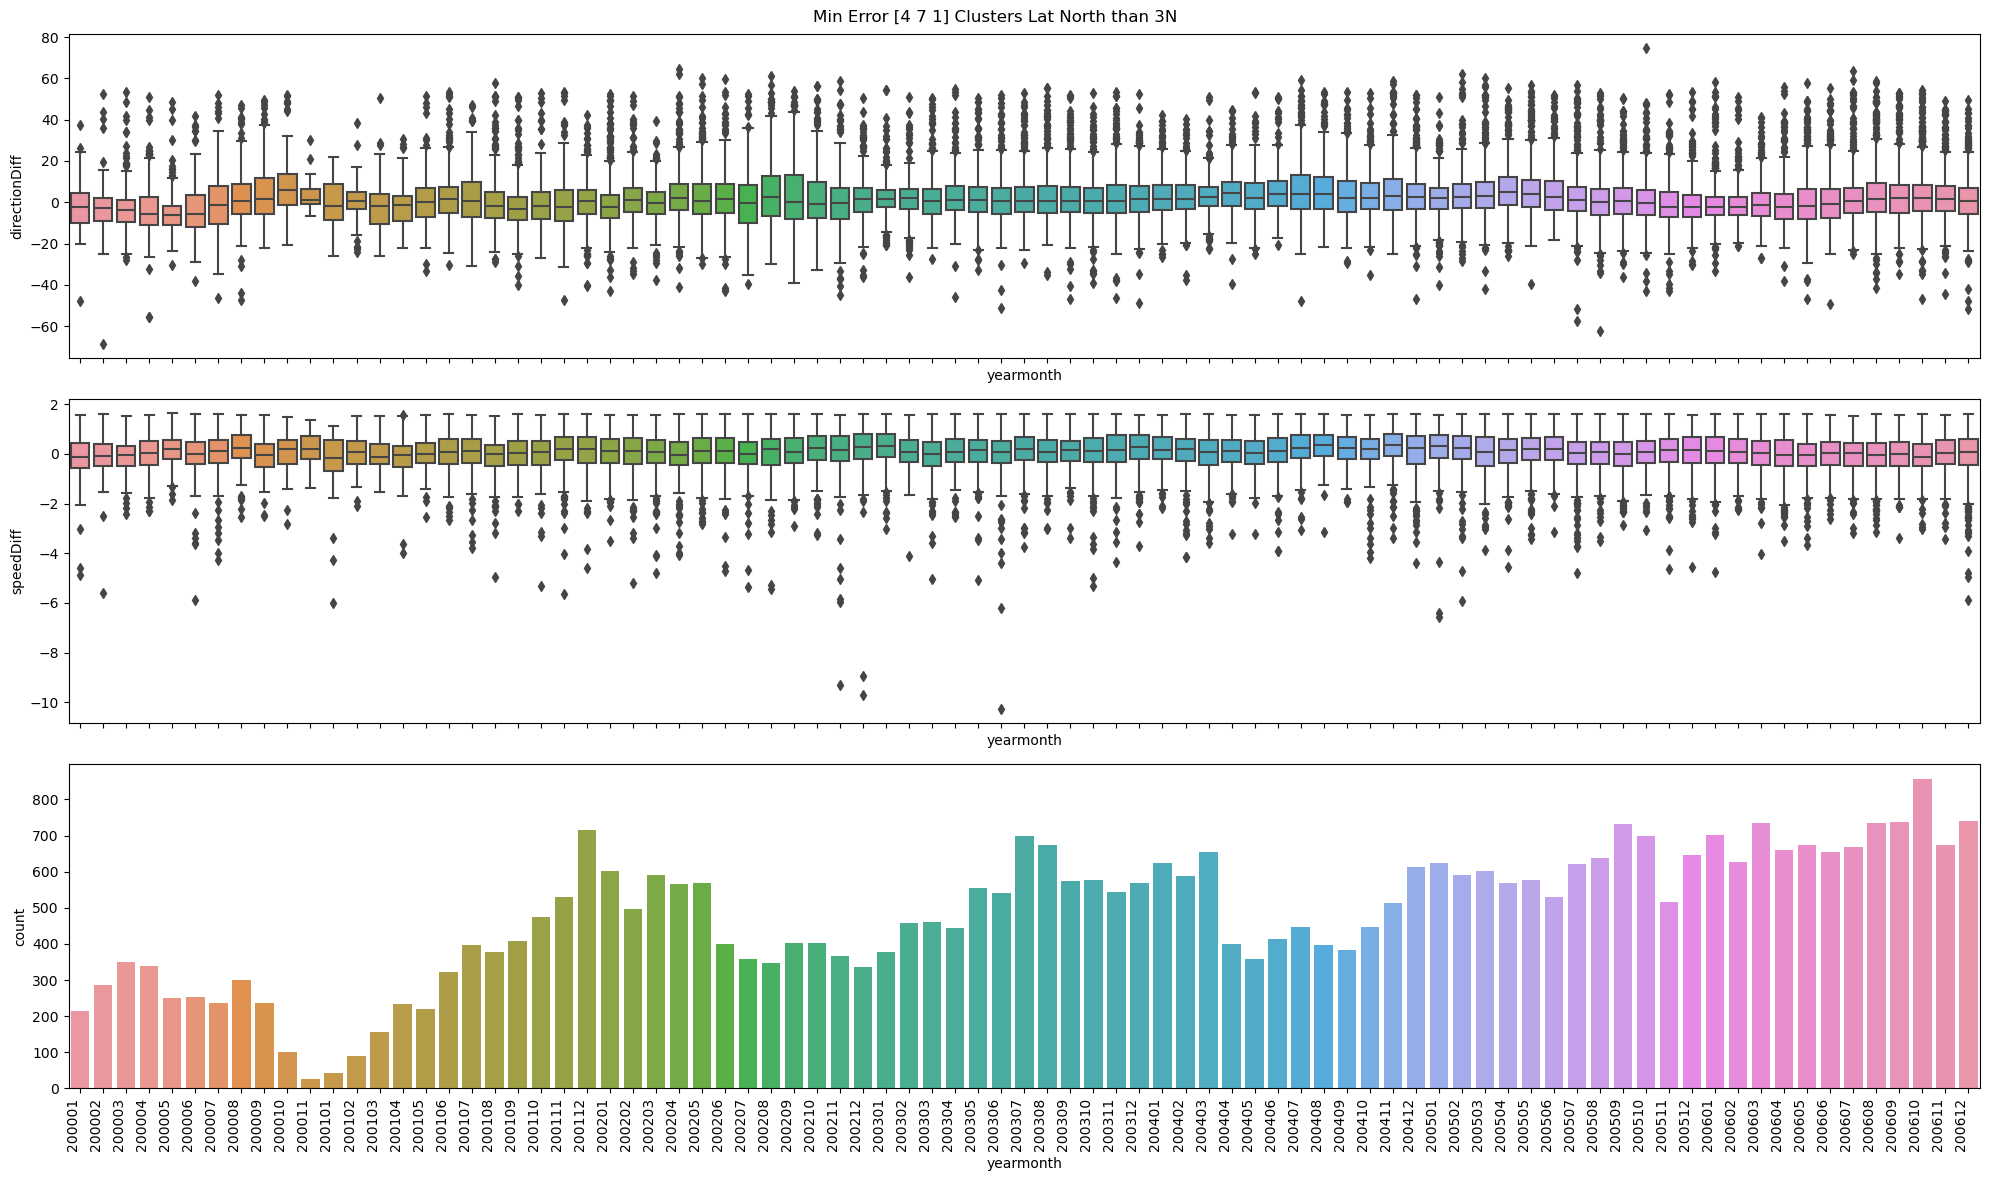

In [13]:
fig, axes = plt.subplots(nrows=3, figsize=(20,12), sharex=True)
lat = 3
lon = -140
subDF = df.loc[df['lat'] >= lat]
subDF = subDF.loc[subDF['label'].isin([4,7,1])]

ax = axes[0]
sns.boxplot(subDF, x="yearmonth", y="directionDiff", ax =ax)
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=90, ha='right')

ax = axes[1]
sns.boxplot(subDF, x="yearmonth", y="speedDiff", ax =ax)
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=90, ha='right')

ax = axes[2]
sns.countplot(subDF, x="yearmonth", ax =ax)
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=90, ha='right')

plt.suptitle('Min Error [4 7 1] Clusters Lat North than 3N')
plt.tight_layout()
plt.savefig('MinError_471_ClustersError_LatNorththan3.png', dpi=100)

/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecat

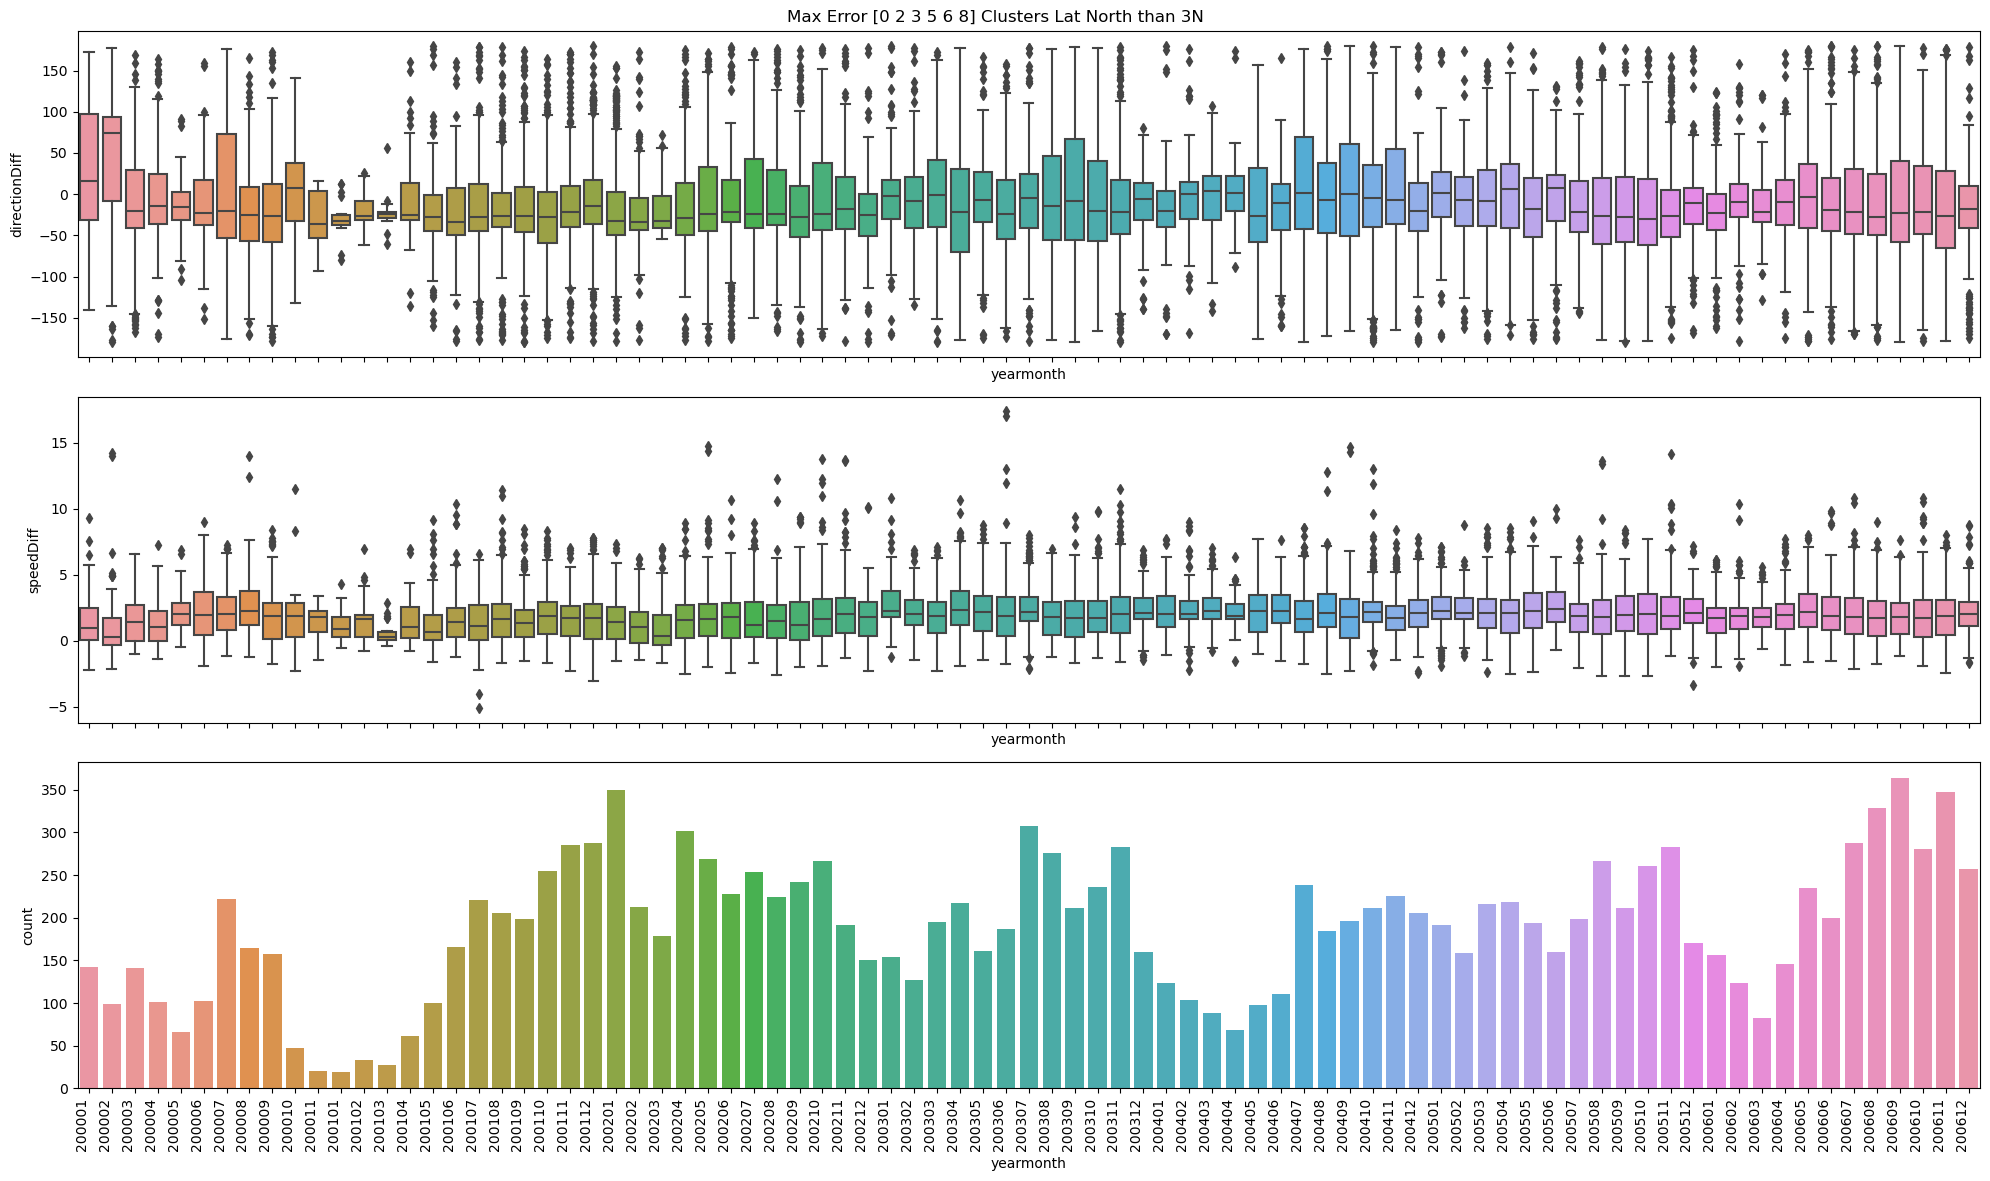

In [14]:
fig, axes = plt.subplots(nrows=3, figsize=(20,12), sharex=True)
lat = 3
lon = -140
subDF = df.loc[df['lat'] > lat]
subDF = subDF.loc[subDF['label'].isin([0,2,3,5,6,8])]

ax = axes[0]
sns.boxplot(subDF, x="yearmonth", y="directionDiff", ax =ax)
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=90, ha='right')

ax = axes[1]
sns.boxplot(subDF, x="yearmonth", y="speedDiff", ax =ax)
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=90, ha='right')

ax = axes[2]
sns.countplot(subDF, x="yearmonth", ax =ax)
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=90, ha='right')

plt.suptitle('Max Error [0 2 3 5 6 8] Clusters Lat North than 3N')
plt.tight_layout()
plt.savefig('maxError_not471_ClustersError_LatNorththan3.png', dpi=100)

/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecat

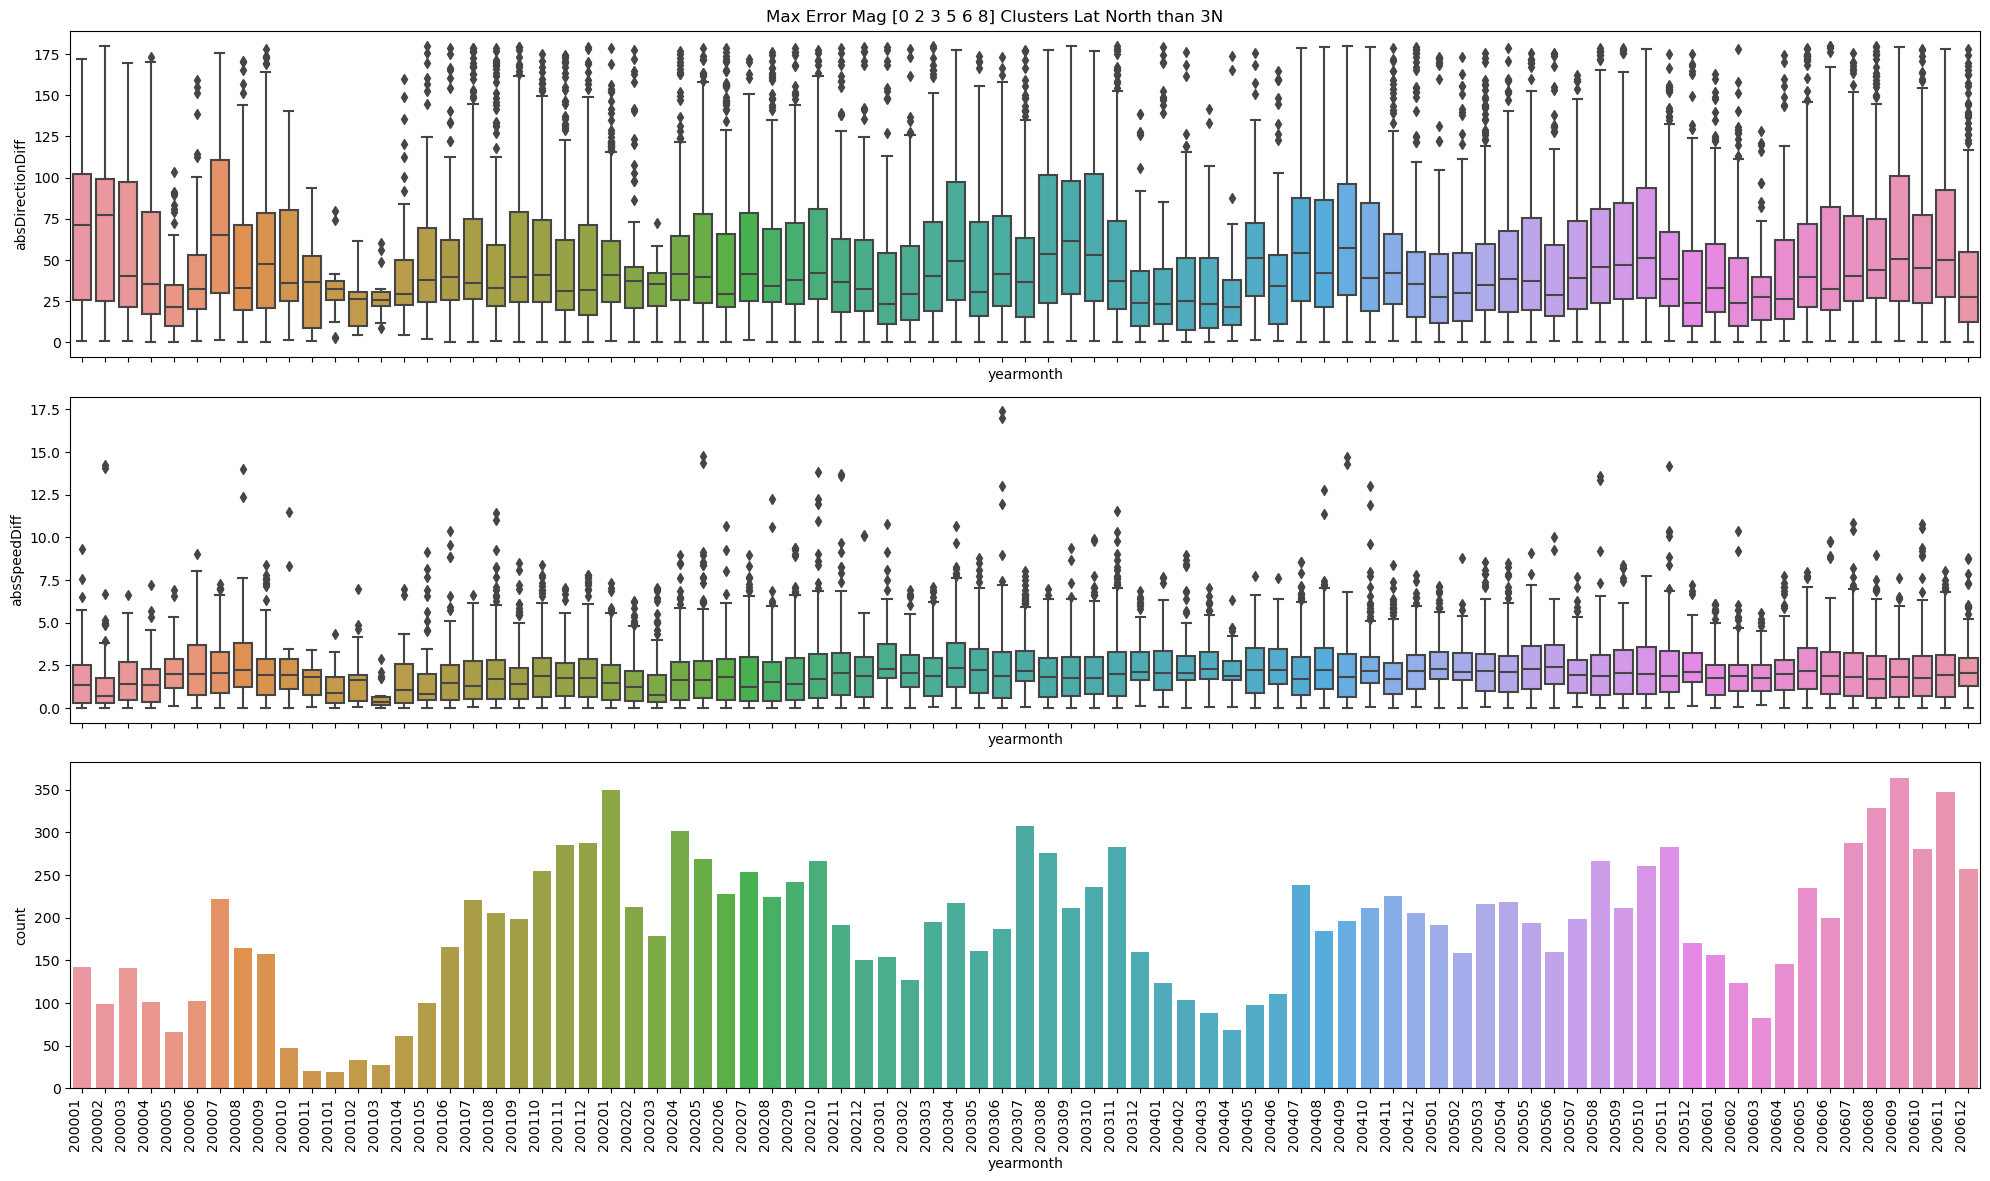

In [15]:
fig, axes = plt.subplots(nrows=3, figsize=(20,12), sharex=True)
lat = 3
lon = -140
subDF = df.loc[df['lat'] > lat]
subDF = subDF.loc[subDF['label'].isin([0,2,3,5,6,8])]

ax = axes[0]
sns.boxplot(subDF, x="yearmonth", y="absDirectionDiff", ax =ax)
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=90, ha='right')

ax = axes[1]
sns.boxplot(subDF, x="yearmonth", y="absSpeedDiff", ax =ax)
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=90, ha='right')

ax = axes[2]
sns.countplot(subDF, x="yearmonth", ax =ax)
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=90, ha='right')

plt.suptitle('Max Error Mag [0 2 3 5 6 8] Clusters Lat North than 3N')
plt.tight_layout()
plt.savefig('maxErrorMag_not471_ClustersError_LatNorththan3.png', dpi=100)

/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecat

<Axes: xlabel='dateTime', ylabel='directionDiff'>

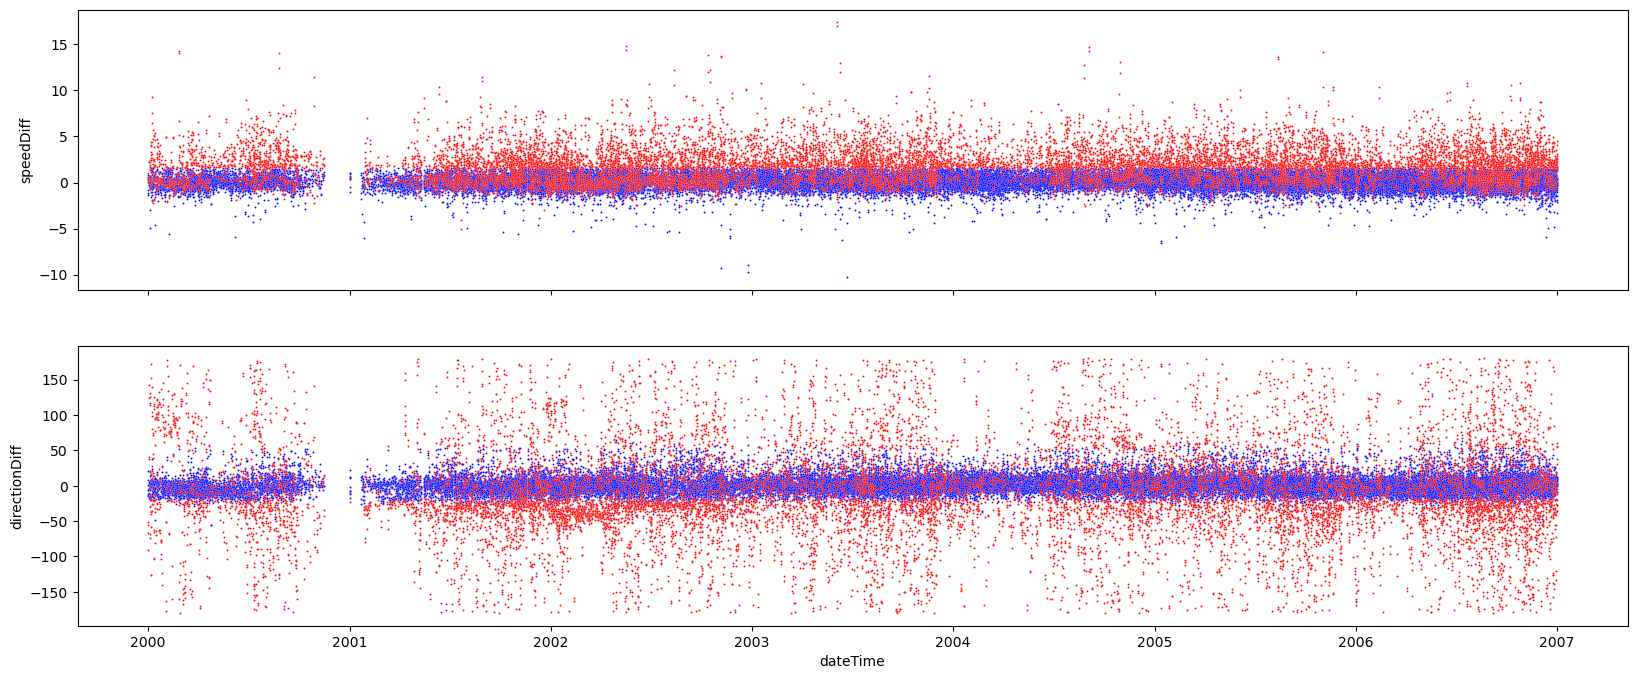

In [16]:
fig, axes = plt.subplots(nrows=2, figsize=(20,8), sharex=True)
lat = 3
lon = -140

s = 2

subDF = df.loc[df['lat'] > lat]
subDF1 = subDF.loc[subDF['label'].isin([0,2,3,5,6,8])]
#subDF1 = subDF.loc[subDF['label'].isin([0])]
subDF2 = subDF.loc[subDF['label'].isin([1,4,7])]

ax = axes[0]
sns.scatterplot(subDF2, x="dateTime", y="speedDiff", s=s, color = 'blue', ax =ax)
sns.scatterplot(subDF1, x="dateTime", y="speedDiff", s=s, color = 'red', ax =ax)
#ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=90, ha='right')

ax = axes[1]
sns.scatterplot(subDF2, x="dateTime", y="directionDiff", s=s, color = 'blue', ax =ax)
sns.scatterplot(subDF1, x="dateTime", y="directionDiff", s=s, color = 'red', ax =ax)
#ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=90, ha='right')

# ax = axes[2]
# sns.countplot(subDF, x="yearmonth", ax =ax)
# ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=90, ha='right')

# plt.suptitle('Max Error Mag [0 2 3 5 6 8] Clusters Lat North than 3N')
# plt.tight_layout()
# plt.savefig('maxErrorMag_not471_ClustersError_LatNorththan3.png', dpi=100)

In [18]:
from matplotlib import cm
import matplotlib.cbook as cbook
import matplotlib.colors as colors

def pdfPlotTest(ax, xlabel, ylabel, color, subDF, ymin, ymax):
    
    s = sns.kdeplot(subDF, x=xlabel, y=ylabel,
                    levels=20, linewidths=1, 
                    color=color, ax = ax)

    ax.set_ylim(ymin, ymax)
    
    
    

/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option i

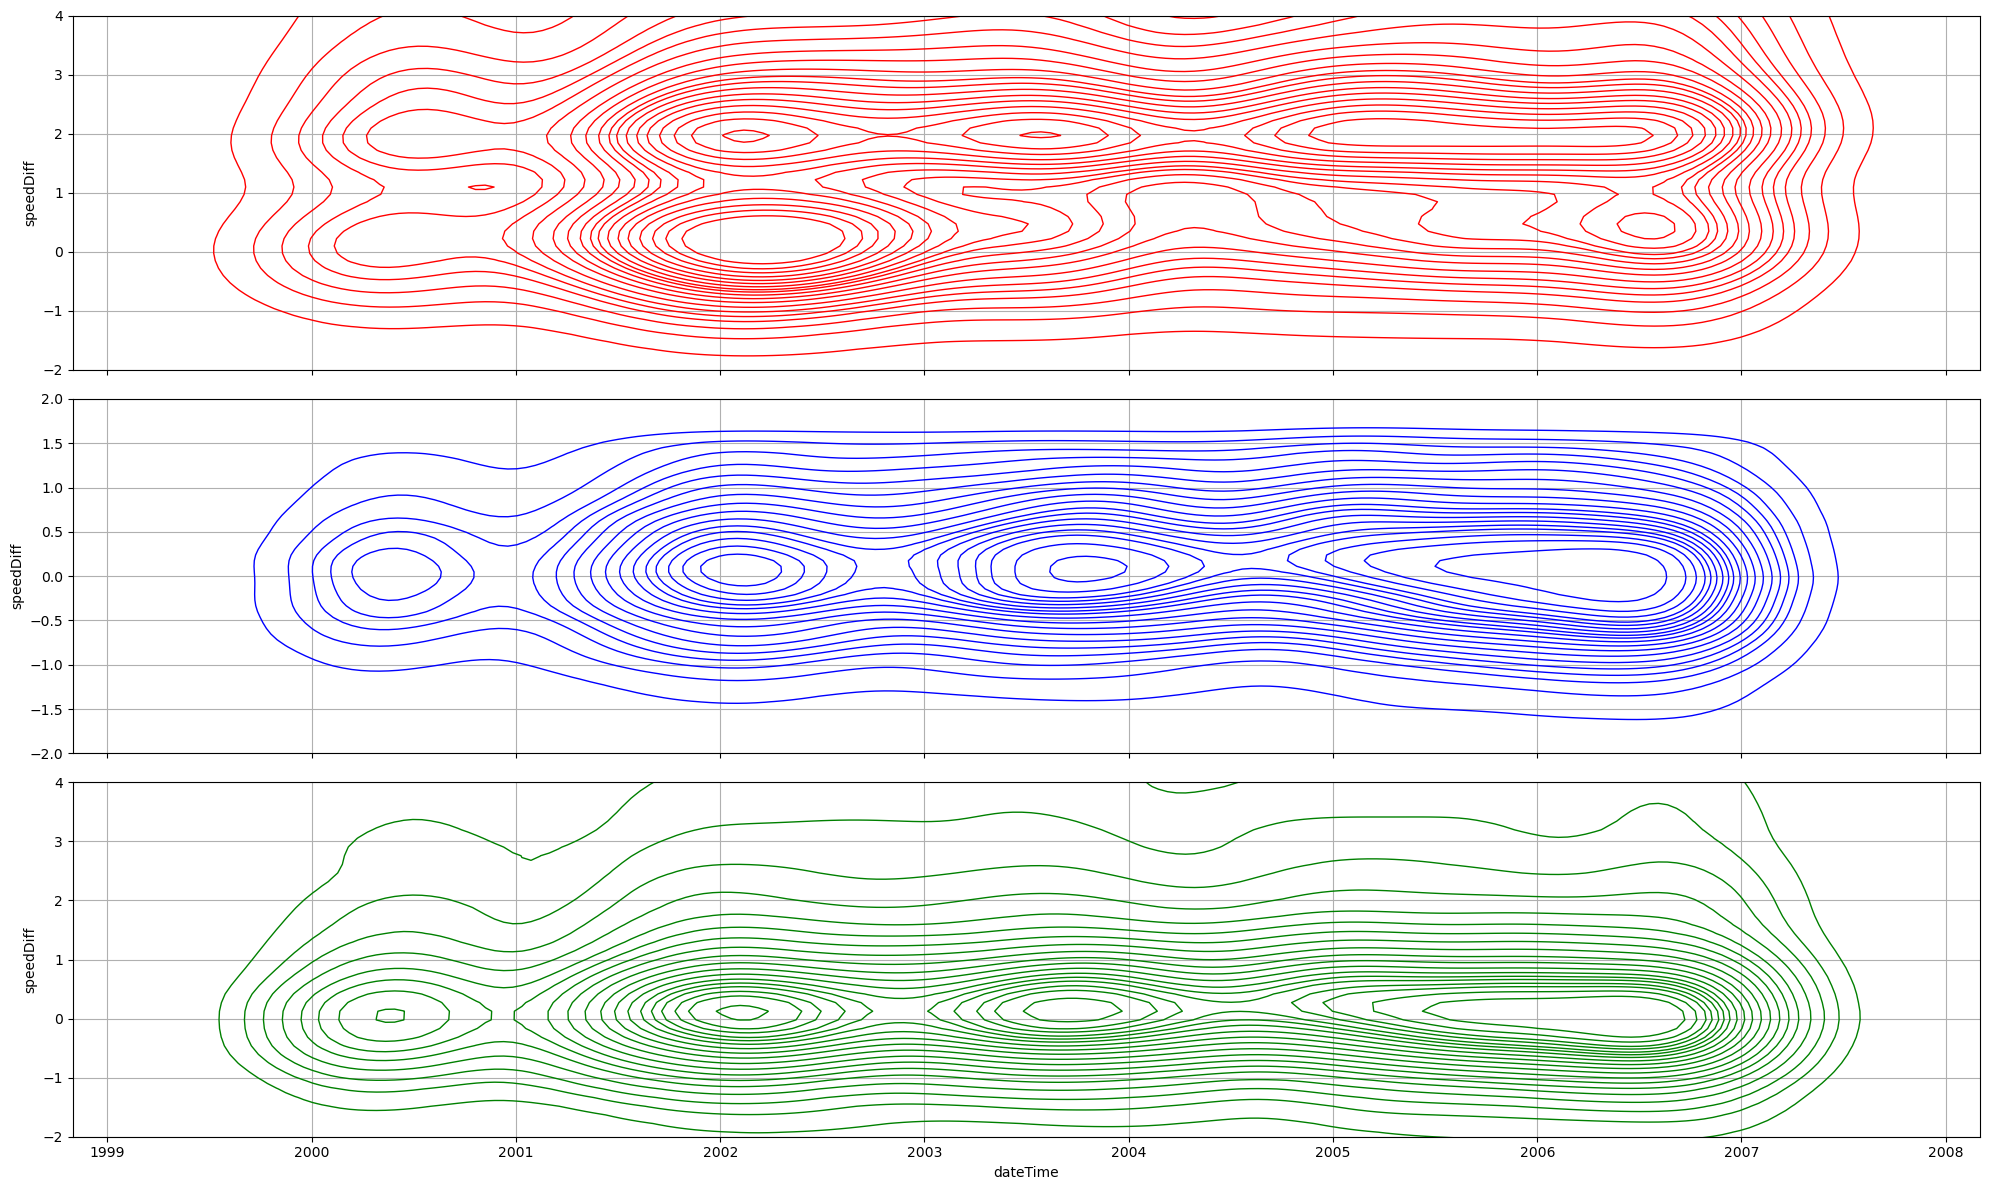

In [19]:
fig, axes = plt.subplots(nrows=3, figsize=(20,12), sharex=True)
lat = 3
lon = -140

s = 1

subDF = df.loc[df['lat'] > lat]
subDF_e = subDF.loc[subDF['label'].isin([0,2,3,5,6,8])]
subDF_c = subDF.loc[subDF['label'].isin([1,4,7])]

ax = axes[0]
xlabel="dateTime"
ylabel="speedDiff"

pdfPlotTest(ax, xlabel, ylabel, 'red', subDF_e, ymin=-2, ymax=4)
ax.grid(axis='both', which = 'both', visible=True)
ax = axes[1]
pdfPlotTest(ax, xlabel, ylabel, 'blue', subDF_c, ymin=-2, ymax=2)
ax.grid(axis='both', which = 'both', visible=True)
ax = axes[2]
pdfPlotTest(ax, xlabel, ylabel, 'green', subDF, ymin=-2, ymax=4)
ax.grid(axis='both', which = 'both', visible=True)

plt.tight_layout()
plt.savefig('pdfSpdErrorWithTime.png', dpi=100)

/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option i

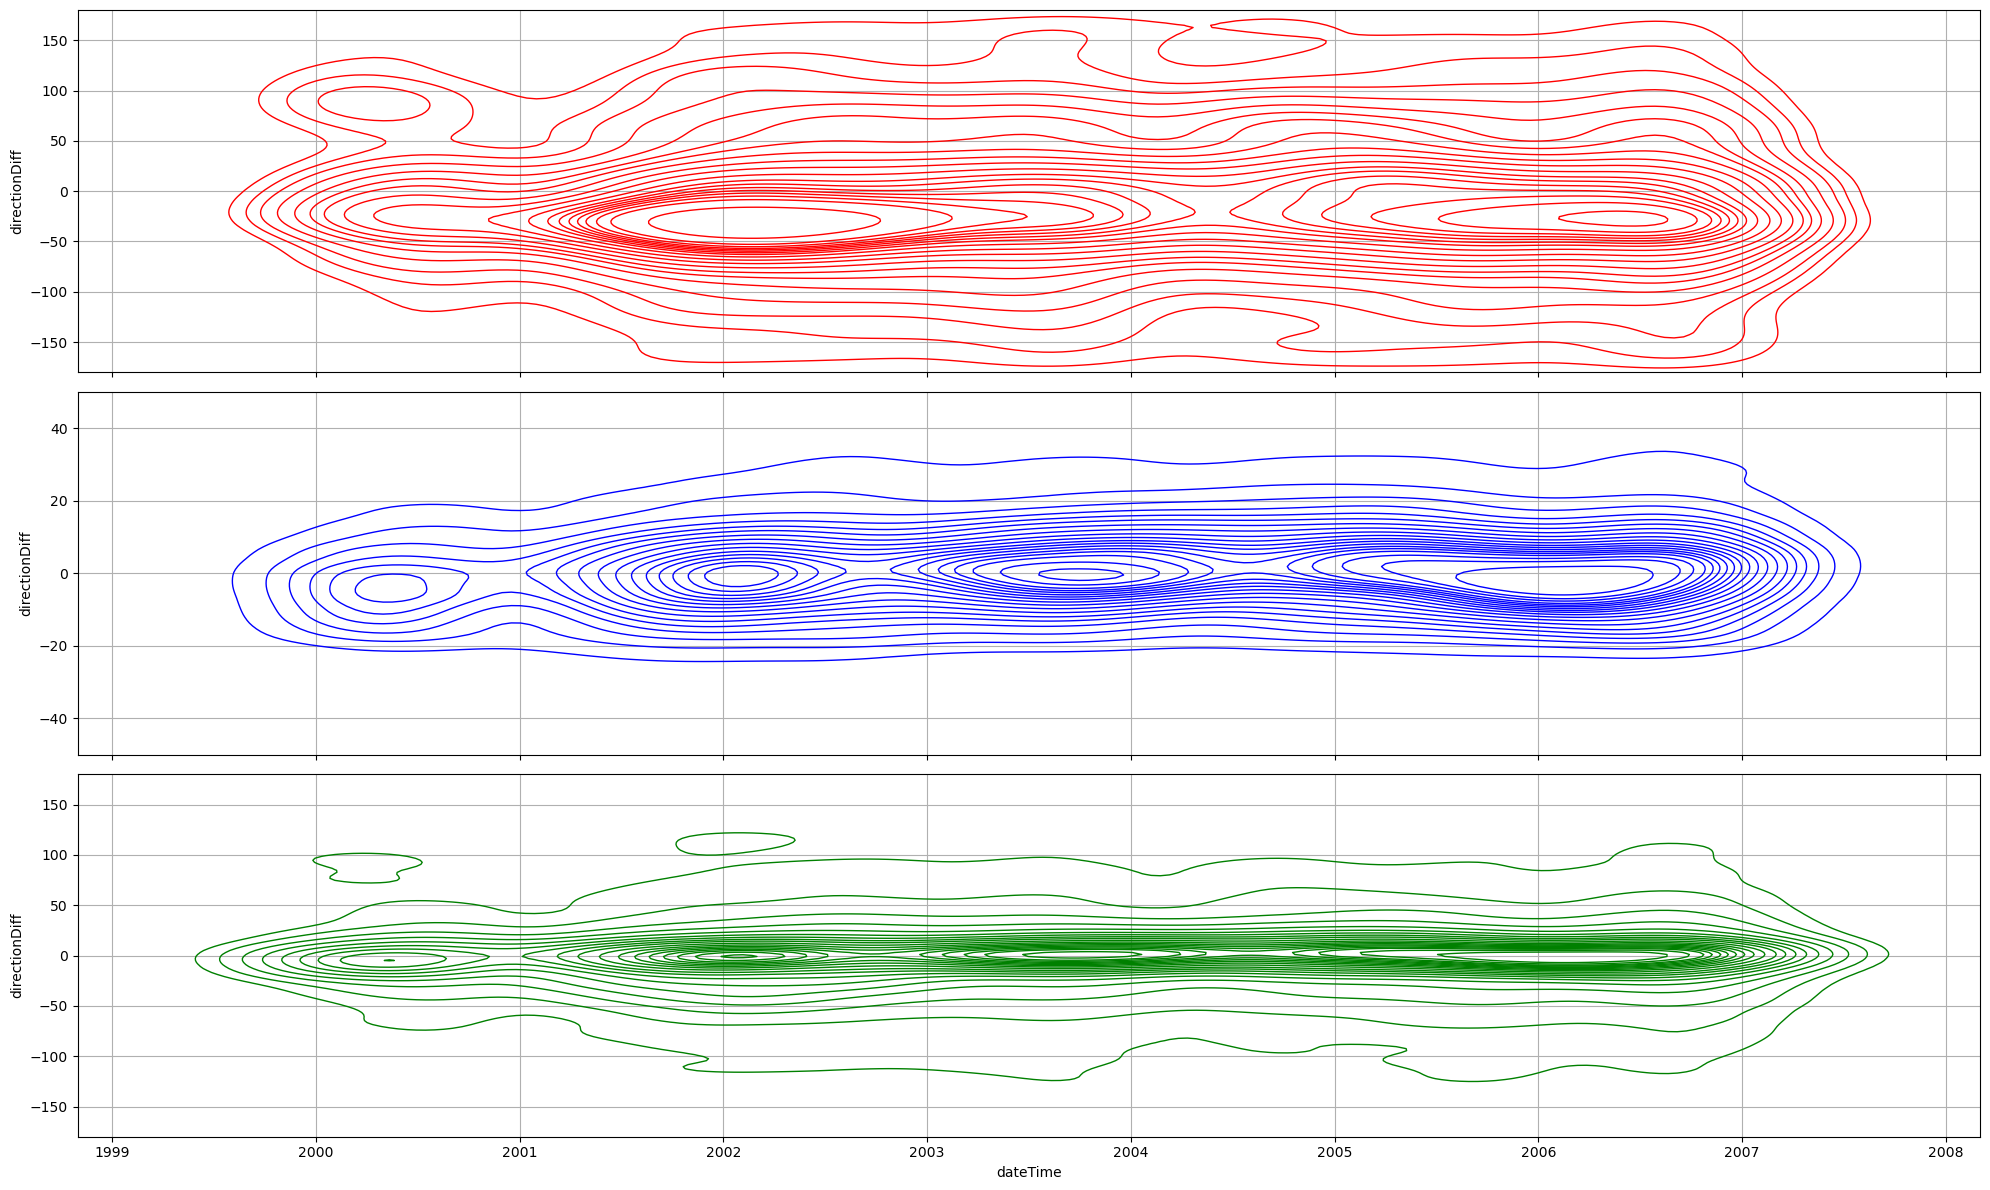

In [20]:
fig, axes = plt.subplots(nrows=3, figsize=(20,12), sharex=True)
lat = 3
lon = -140

s = 1

subDF = df.loc[df['lat'] > lat]
subDF_e = subDF.loc[subDF['label'].isin([0,2,3,5,6,8])]
subDF_c = subDF.loc[subDF['label'].isin([1,4,7])]

ax = axes[0]
xlabel="dateTime"
ylabel="directionDiff"

pdfPlotTest(ax, xlabel, ylabel, 'red', subDF_e, ymin=-180, ymax=180)
ax.grid(axis='both', which = 'both', visible=True)
ax = axes[1]
pdfPlotTest(ax, xlabel, ylabel, 'blue', subDF_c, ymin=-50, ymax=50)
ax.grid(axis='both', which = 'both', visible=True)
ax = axes[2]
pdfPlotTest(ax, xlabel, ylabel, 'green', subDF, ymin=-180, ymax=180)
ax.grid(axis='both', which = 'both', visible=True)

plt.tight_layout()
plt.savefig('pdfDirErrorWithTime.png', dpi=100)

/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option i

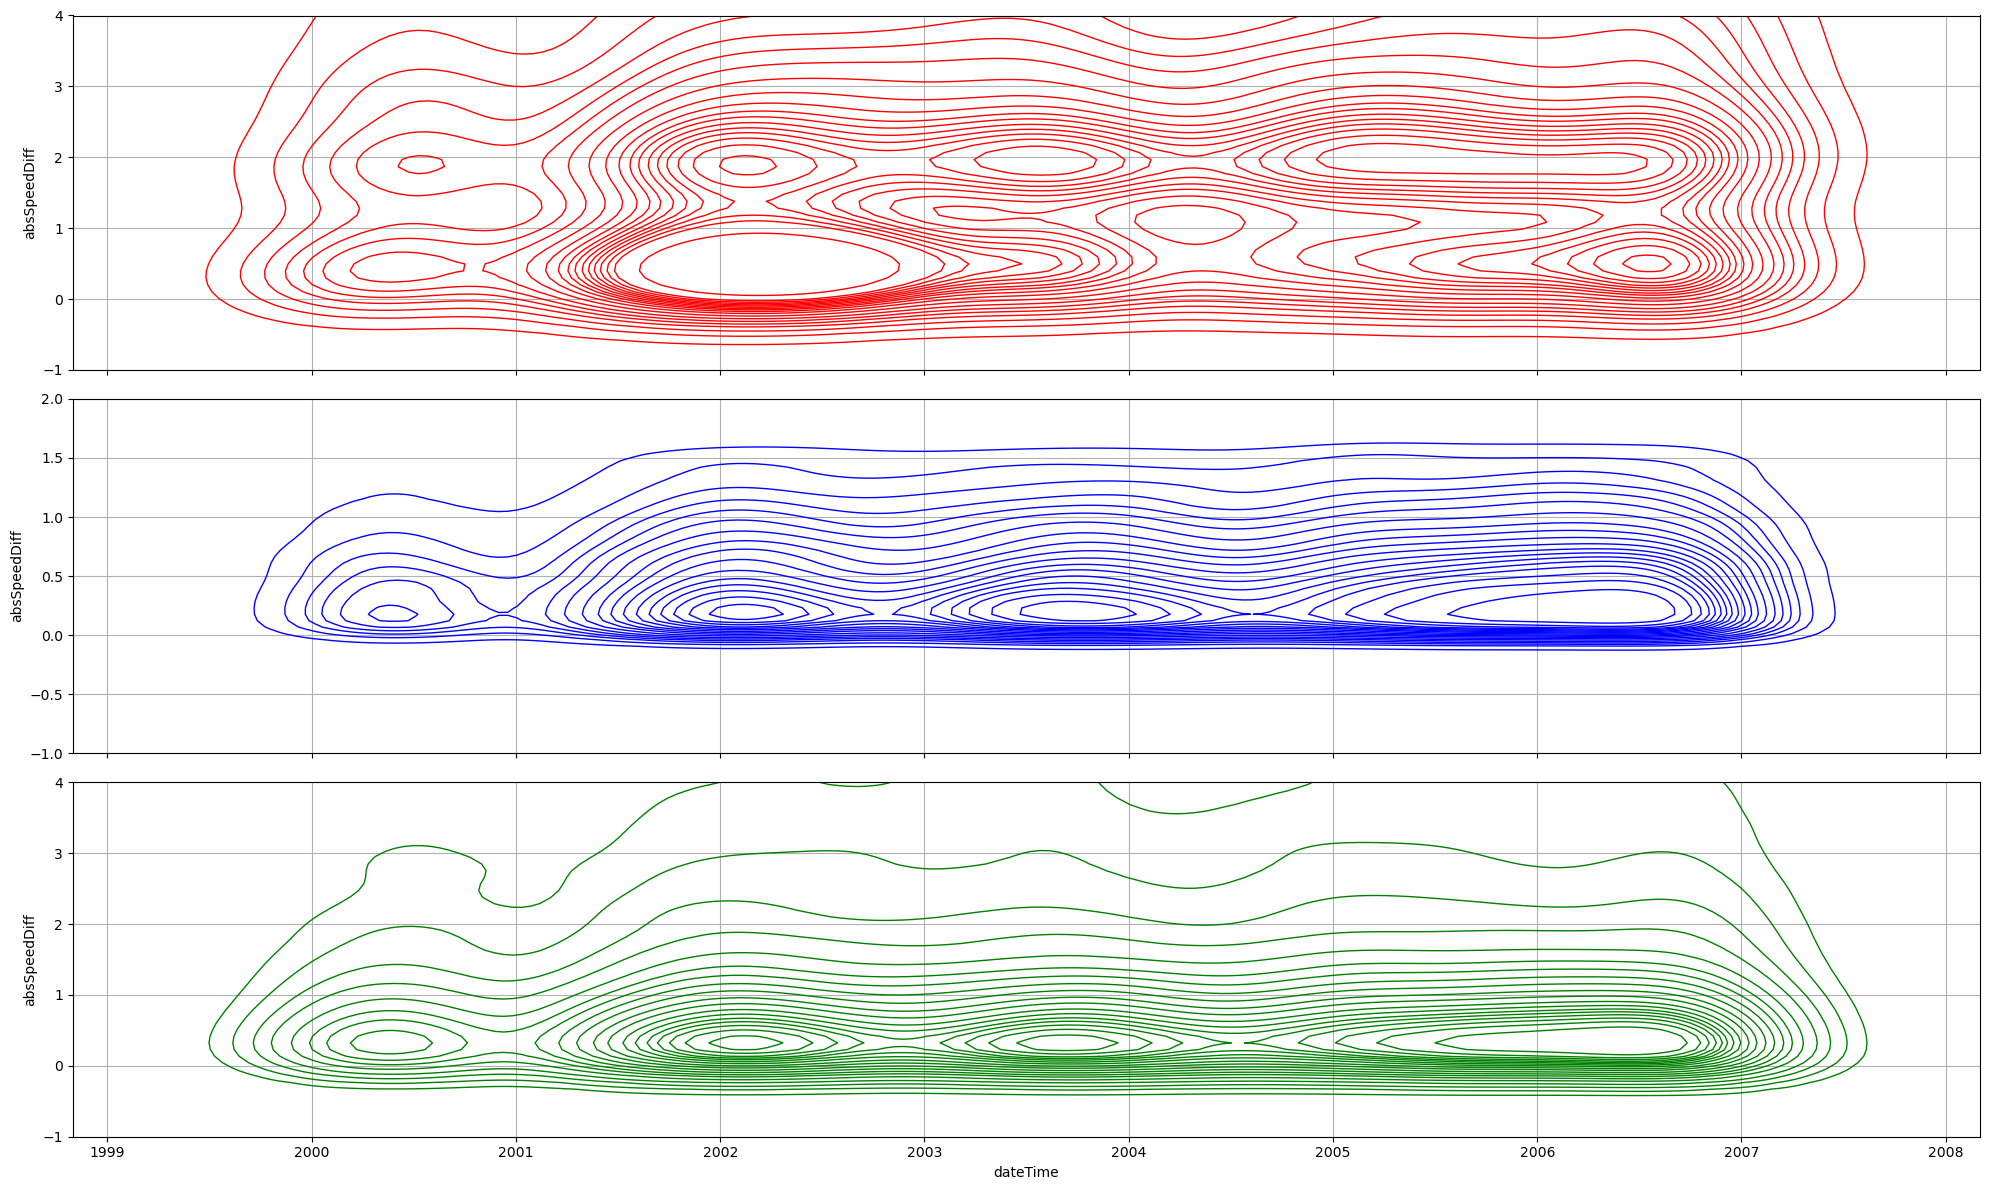

In [21]:
fig, axes = plt.subplots(nrows=3, figsize=(20,12), sharex=True)
lat = 3
lon = -140

s = 1

subDF = df.loc[df['lat'] > lat]
subDF_e = subDF.loc[subDF['label'].isin([0,2,3,5,6,8])]
subDF_c = subDF.loc[subDF['label'].isin([1,4,7])]

ax = axes[0]
xlabel="dateTime"
ylabel="absSpeedDiff"

pdfPlotTest(ax, xlabel, ylabel, 'red', subDF_e, ymin=-1, ymax=4)
ax.grid(axis='both', which = 'both', visible=True)
ax = axes[1]
pdfPlotTest(ax, xlabel, ylabel, 'blue', subDF_c, ymin=-1, ymax=2)
ax.grid(axis='both', which = 'both', visible=True)
ax = axes[2]
pdfPlotTest(ax, xlabel, ylabel, 'green', subDF, ymin=-1, ymax=4)
ax.grid(axis='both', which = 'both', visible=True)

plt.tight_layout()
plt.savefig('pdfAbsSpdErrorWithTime.png', dpi=100)

/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option i

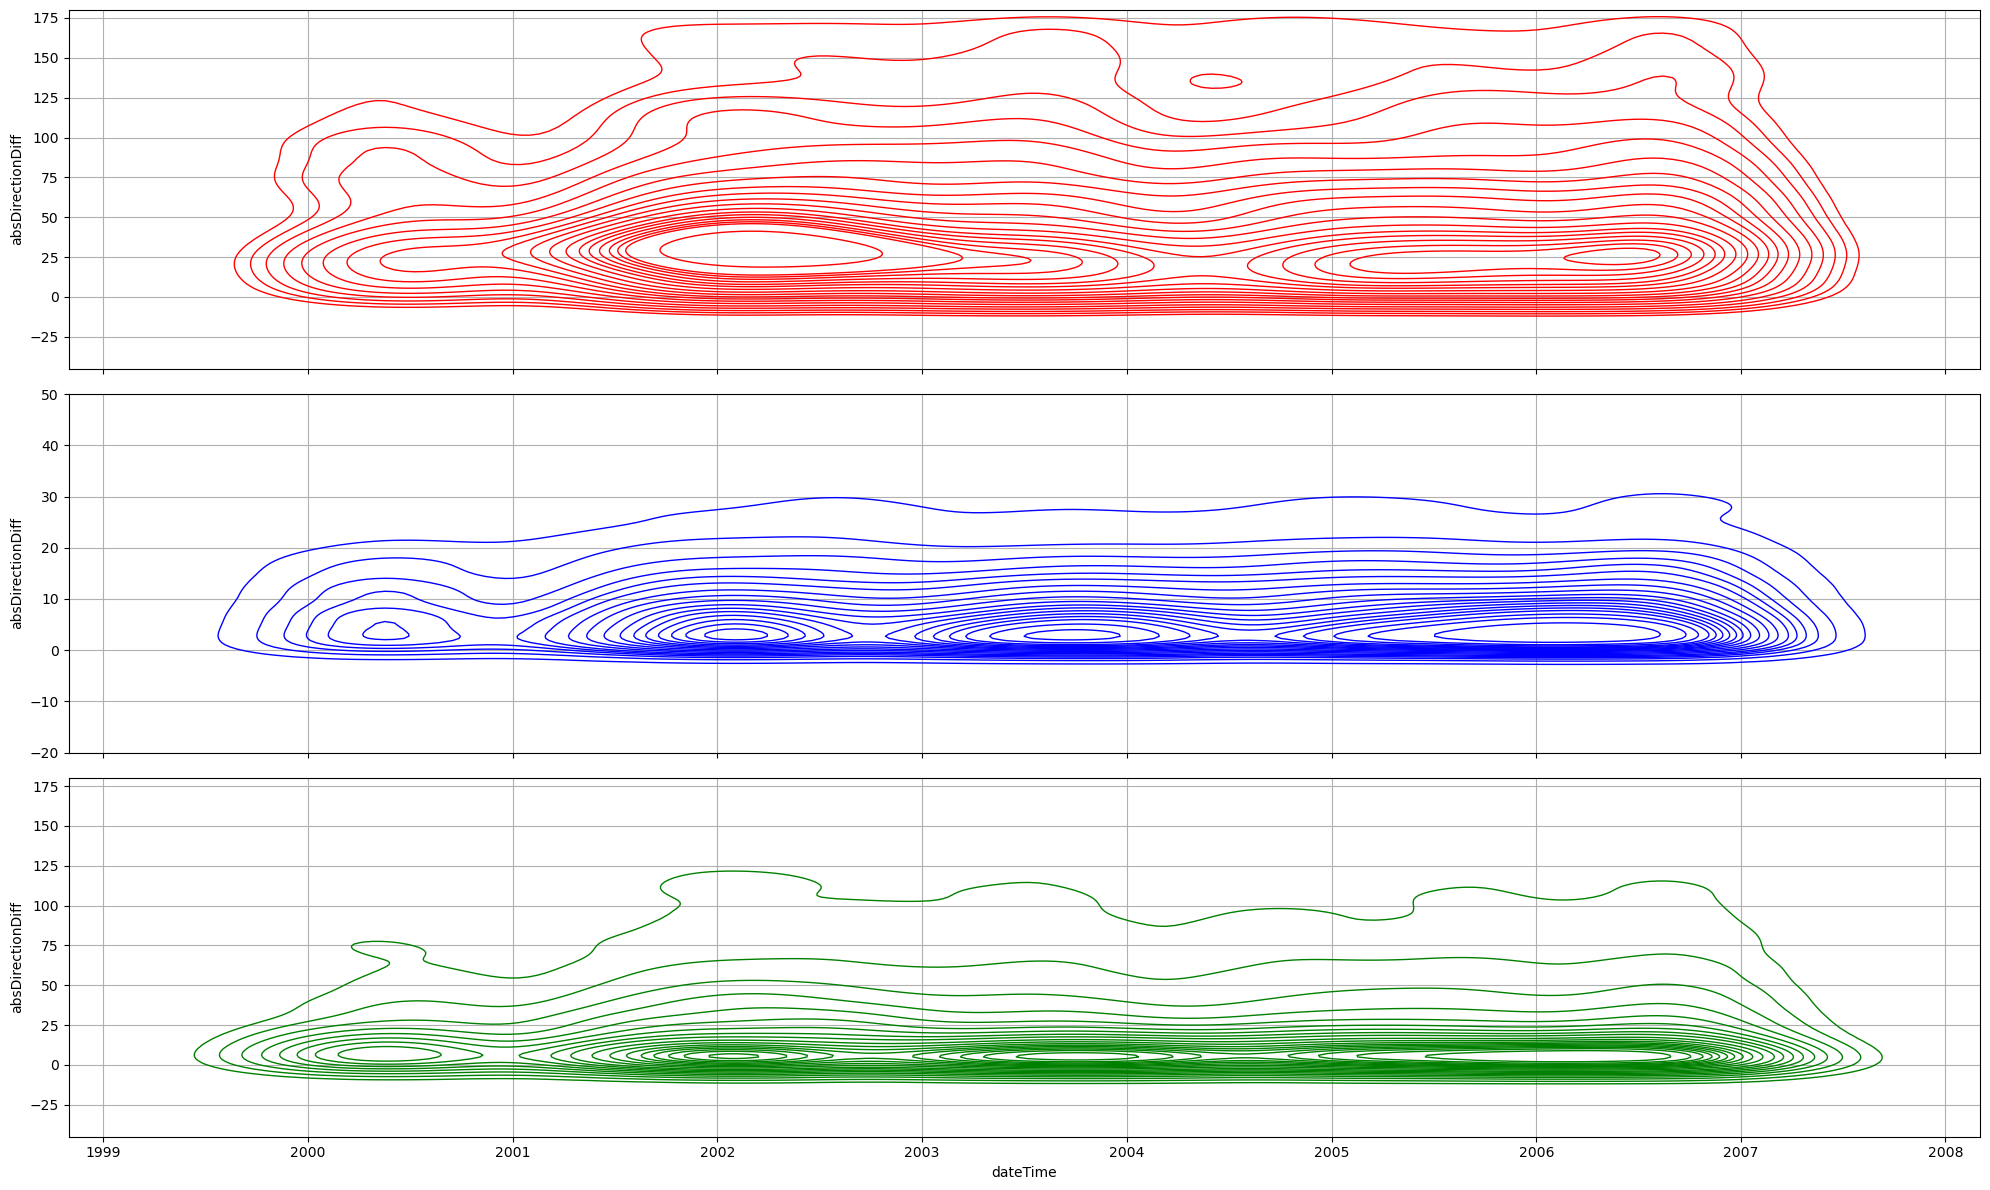

In [22]:
fig, axes = plt.subplots(nrows=3, figsize=(20,12), sharex=True)
lat = 3
lon = -140

s = 1

subDF = df.loc[df['lat'] > lat]
subDF_e = subDF.loc[subDF['label'].isin([0,2,3,5,6,8])]
subDF_c = subDF.loc[subDF['label'].isin([1,4,7])]

ax = axes[0]
xlabel="dateTime"
ylabel="absDirectionDiff"

pdfPlotTest(ax, xlabel, ylabel, 'red', subDF_e, ymin=-45, ymax=180)
ax.grid(axis='both', which = 'both', visible=True)
ax = axes[1]
pdfPlotTest(ax, xlabel, ylabel, 'blue', subDF_c, ymin=-20, ymax=50)
ax.grid(axis='both', which = 'both', visible=True)
ax = axes[2]
pdfPlotTest(ax, xlabel, ylabel, 'green', subDF, ymin=-45, ymax=180)
ax.grid(axis='both', which = 'both', visible=True)

plt.tight_layout()
plt.savefig('pdfAbsDirErrorWithTime.png', dpi=100)

/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='label', ylabel='count'>

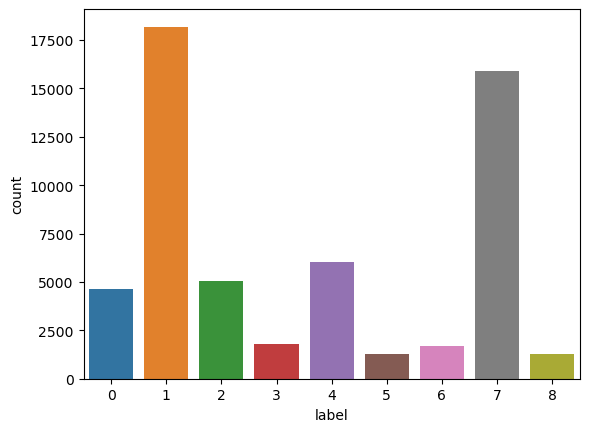

In [23]:
sns.countplot(subDF, x='label')

/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='label', ylabel='count'>

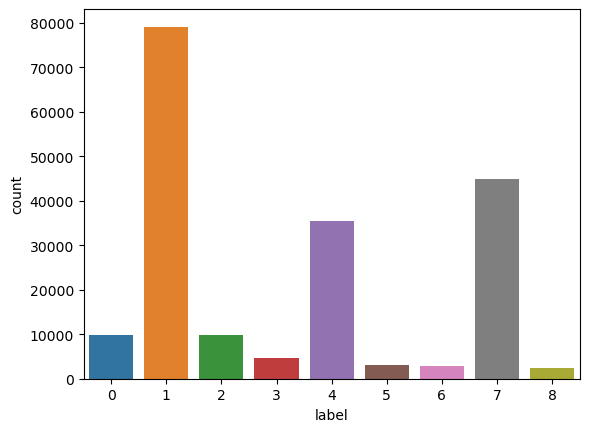

In [24]:
sns.countplot(df, x='label')

In [41]:
df4Stat = df.drop(columns = ['dateTime',
                             'time', 
                             'lat', 
                             'lon',
                             'satLon', 
                             'satLat',
                             'Deployment Classifier',
                             'yearmonth',
                             'month'])

U10N_QS U10N_dir_QS satTimeDiff      dist  U10N_TAO U10N_dir_TAO  \
0   5.74714  325.648834       276.0  6.455491  5.926161   326.399994   
1   5.74714  325.648834      -324.0  6.455491  5.836925   321.799988   
2  6.211579  323.708984       271.0  6.615148  5.541527   321.299988   
3  6.211579  323.708984      -329.0  6.615148   5.99286   320.600006   
4  5.837174  318.623627       457.0  5.688329  6.055364   317.799988   

  U10N_TAO2 U10N_dir_TAO2 U10N_x_TAO2 U10N_y_TAO2    SST_TAO     RH_TAO  \
0  5.925004    123.572121   -3.276446    4.936657  23.745001  73.830002   
1  5.842724    128.187561   -3.612193    4.592328     23.743  73.300003   
2  5.537891    128.713104   -3.463514    4.321145     23.938  75.730003   
3  5.989744    129.348511   -3.797712     4.63189  23.927999  75.599998   
4  6.050257    132.133926   -4.058911    4.486742  23.716999  73.879997   

    AIRT_TAO speedDiff absSpeedDiff directionDiff absDirectionDiff  label  
0      22.93 -0.179021     0.179021      -0.75116          0.75116      1  
1      22.84 -0.089785     0.089785      3.848846         3.848846      1  
2  23.200001  0.670052     0.670052      2.408997         2.408997      7  
3  23.190001  0.218719     0.218719      3.108978         3.108978      1  
4  23.040001  -0.21819      0.21819      0.823639         0.823639      1

In [65]:
labels = np.arange(9)
dataNames = columns = df4Stat.keys()[:-1]
stats = ['mean', 'std. dev']
nx, ny, nz = len(labels), len(stats), len(dataNames)
dataArray = np.empty((nx, ny, nz), dtype=float)

for i in range(nx):
    label = labels[i]
    subDF = df4Stat.loc[df['label'] == label]
    ssubDF = subDF.drop(columns = ['label'])
    mean = ssubDF.mean(axis=0)
    std = ssubDF.std(axis=0)
    dataArray[i,0,:] = mean
    dataArray[i,1,:] = std

In [66]:
dataXarr = xr.DataArray(dataArray, coords = {'label':np.arange(9),
                                             'stats' : ['mean', 'std. dev'],
                                              'vars' : df4Stat.keys()[:-1]})

Text(0, 0.5, 'satTimeDiff')

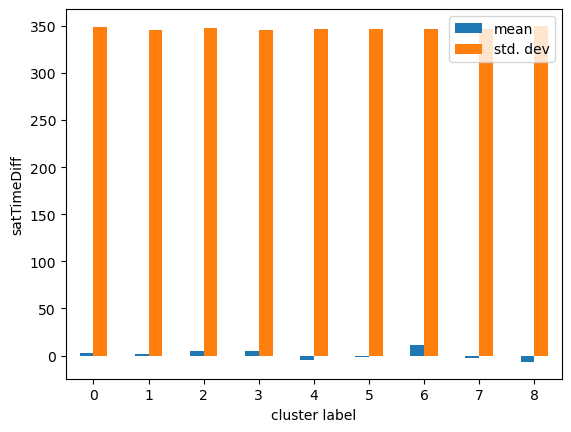

In [113]:
varname = 'satTimeDiff'
def saveSatsFig(varname):
    fname = f'stats_{varmame}.png'
    lb1Data= dataXarr.sel(vars=varname)
    test = pd.DataFrame(lb1Data, index = np.arange(9), columns= ['mean', 'std. dev'])
    #test.reset_index(inplace=True)
    #test = test.rename(index={'index': 'label'})
    ax = test.plot.bar(rot=0)
    ax.set_xlabel('cluster label')
    ax.set_ylabel(varname)
    fig = ax.get_figure()
    fig.savefig(fname, dpi =100)


In [97]:
test

index       mean    std. dev
0      0   3.049558  348.251638
1      1   2.010528  345.924875
2      2   5.044000  347.279473
3      3   4.862454  345.346087
4      4  -5.210813  347.073513
5      5  -1.282170  346.570610
6      6  10.743819  346.313566
7      7  -2.207954  346.207182
8      8  -6.743295  349.920048

In [85]:
subDf = df.loc[df['label']==0]
mean = subDf.mean(axis=0)
std = subDf.std(axis=0)

In [86]:
mean

dateTime                 2003-08-02 01:13:06.119679104
time                                  428634786.119679
lat                                           1.807423
lon                                          210.97008
U10N_QS                                       5.164263
U10N_dir_QS                                 247.939818
satTimeDiff                                   3.049558
dist                                          4.843163
satLon                                       210.97046
satLat                                        1.807433
U10N_TAO                                      4.764782
U10N_dir_TAO                                246.784238
U10N_TAO2                                      4.76471
U10N_dir_TAO2                               139.237558
U10N_x_TAO2                                  -1.777414
U10N_y_TAO2                                     2.4702
SST_TAO                                      28.232809
RH_TAO                                       83.625138
AIRT_TAO  

In [87]:
std

dateTime                 722 days 00:40:05.331460216
time                                  62383205.33146
lat                                         5.250774
lon                                        34.450698
U10N_QS                                     2.374282
U10N_dir_QS                                84.372447
satTimeDiff                               348.251638
dist                                        1.854992
satLon                                     34.450629
satLat                                       5.25064
U10N_TAO                                    2.294173
U10N_dir_TAO                              114.889756
U10N_TAO2                                   2.294147
U10N_dir_TAO2                               66.64579
U10N_x_TAO2                                 3.232641
U10N_y_TAO2                                 2.873308
SST_TAO                                     1.706973
RH_TAO                                      6.312573
AIRT_TAO                                     1